# German Traffic Sign Classification

---

In [1]:
import pandas as pd

df_total = pd.DataFrame()
for i in range(0,43):
    csv_file = '..\..\datasets\GTSRB_data\Final_Training\Images\%05d\GT-%05d.csv' % (i, i)
    the_path = '..\..\datasets\GTSRB_data\Final_Training\Images\%05d\\' % (i) 
    df=pd.read_csv(csv_file)
    df['Filename'] = the_path + df['Filename'] # prepend path to filename
    df_total = df_total.append(df) # append all dataframes to df_total
    
df_total.info() # display some information
#df_total['Filename'].head() # look at a few rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39209 entries, 0 to 239
Data columns (total 9 columns):
Filename    39209 non-null object
Width       39209 non-null int64
Height      39209 non-null int64
Roi.X1      39209 non-null int64
Roi.Y1      39209 non-null int64
Roi.X2      39209 non-null int64
Roi.Y2      39209 non-null int64
ClassId     39209 non-null int64
Damage      39209 non-null int64
dtypes: int64(8), object(1)
memory usage: 3.0+ MB


In [2]:
df_total = df_total.astype({"Damage": str}) # convert damage column to string
#df_total.info()

In [3]:
# create trn, val, tst split
import math
from sklearn.utils import shuffle
df_total_shuffled = shuffle(df_total, random_state=42)

trn_percentage = 0.8 # use 80 for training
val_percentage = 0.9 # use samples 0.8 to 0.9 for validation, rest for testing

trn_split = math.floor(len(df_total_shuffled)*trn_percentage)
val_split = math.floor(len(df_total_shuffled)*val_percentage)

df_trn = df_total_shuffled.iloc[0:trn_split]
df_val = df_total_shuffled.iloc[trn_split:val_split]
df_tst = df_total_shuffled.iloc[val_split:]

# check if sizes are correct
print(len(df_trn))
print(len(df_val))
print(len(df_tst))
print(len(df_trn) + len(df_val) + len(df_tst))
print(len(df_total_shuffled))

df_trn.groupby('Damage').count()
#df_val.groupby('Damage').count()
#df_tst.groupby('Damage').count()

31367
3921
3921
39209
39209


,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
Damage,,,,,,,,
0,28385,28385,28385,28385,28385,28385,28385,28385
1,2982,2982,2982,2982,2982,2982,2982,2982


In [4]:
from keras_preprocessing.image import ImageDataGenerator

im_w = 64
im_h = 64
im_c = 1
bs = 128

datagen_temp = ImageDataGenerator()
gen_temp=datagen_temp.flow_from_dataframe(dataframe=df_trn, directory=".", x_col="Filename", y_col="Damage", class_mode="categorical", target_size=(im_w,im_h), batch_size=bs, color_mode='grayscale')

import numpy as np
X_temp = np.empty((0,im_w,im_h,im_c))
for i in range(0, len(gen_temp)):
    (X,y) = gen_temp[i]
    X_temp = np.concatenate((X_temp,X), axis=0)
X_temp.shape

Found 31367 images belonging to 2 classes.


(31367, 64, 64, 1)

In [5]:
flow_args = dict(directory=".", 
    x_col="Filename", 
    y_col="Damage", 
    class_mode="categorical", 
    target_size=(im_w,im_h), 
    batch_size=bs, 
    color_mode='grayscale')

generator_args = dict(featurewise_center=True, featurewise_std_normalization=True)

# build the generators
datagen_trn=ImageDataGenerator(**generator_args)
datagen_trn.fit(X_temp)
gen_trn=datagen_trn.flow_from_dataframe(dataframe=df_trn, **flow_args)

datagen_val=ImageDataGenerator(**generator_args)
datagen_val.fit(X_temp)
gen_val=datagen_val.flow_from_dataframe(dataframe=df_val, **flow_args)

datagen_tst=ImageDataGenerator(**generator_args)
datagen_tst.fit(X_temp)
gen_tst=datagen_tst.flow_from_dataframe(dataframe=df_tst, **flow_args)

Found 31367 images belonging to 2 classes.
Found 3921 images belonging to 2 classes.
Found 3921 images belonging to 2 classes.


In [6]:
# take a look at images from our generator
X_temp = np.empty((0,im_w,im_h,im_c))
for i in range(0, len(gen_trn)):
    (X,y) = gen_trn[i]
    X_temp = np.concatenate((X_temp,X), axis=0)
X_temp.shape


(31367, 64, 64, 1)

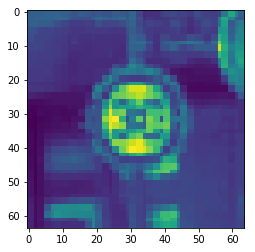

In [7]:
import matplotlib.pyplot as plt

plt.imshow(X_temp[50,:,:,0])
plt.show()


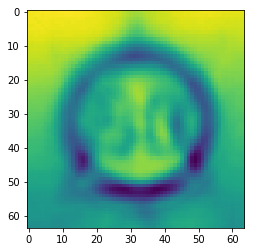

In [8]:
# its a bit worrying that this image is not completely all ones...
plt.imshow(np.std(X_temp[:,:,:,0],axis=0))
plt.show()

**Model architecture**

I use the same architecture as the guys used for classifying sign identity for the german dataset, shown below

![Model](model_architecture.png)



In [10]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from resnet import ResnetBuilder

use_resnet = True

num_classes = 2

if (use_resnet == False):
    # build a simple model
    model = Sequential()

    input_shape = (im_w, im_h, im_c)
    

    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()
else:
    input_shape_resnet = (im_c,im_w,im_h)
    model = ResnetBuilder.build_resnet_18(input_shape_resnet, num_classes)
    model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [11]:
# compile model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [12]:
import numpy as np
import sklearn.metrics

def comp_stats(gen):
    
    y_total = np.empty((0,2))
    for i in range(0, len(gen)):
        (X,y) = gen[i]
        y_total = np.concatenate((y_total,y), axis=0)
    return np.sum(y_total, axis=0)

def comp_metrics(gen, model):
    y_total = np.empty((0,2))
    y_total_pred = np.empty((0,2))
    for i in range(0, len(gen)):
        (X,y) = gen[i]
        y_total = np.concatenate((y_total,y), axis=0)
        y_pred = model.predict(X)
        y_total_pred = np.concatenate((y_total_pred, y_pred), axis=0)
    acc = sklearn.metrics.accuracy_score(y_total, y_total_pred > 0.5)
    
    class_freq = np.sum(y_total,axis=0)
    accuracy_chance = (class_freq[0]+class_freq[1]-class_freq[1])/(class_freq[1]+class_freq[0])
    
    auc = sklearn.metrics.roc_auc_score(y_total, y_total_pred)
    
    apr = sklearn.metrics.average_precision_score(y_total, y_total_pred)
    
    return (acc, accuracy_chance, auc, apr)
    

In [16]:
from keras.callbacks import Callback

class roc_callback(Callback):
    def __init__(self,gen_trn,gen_val,use_trn):
        self.gen_trn = gen_trn
        self.gen_val = gen_val
        self.auc_trn = []
        self.auc_val = []
        self.acc_trn = []
        self.acc_val = []
        self.apr_trn = []
        self.apr_val = []
        self.use_trn = use_trn

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        
        (acc_val_tmp, acc_chance, auc_val_tmp, apr_val_tmp) = comp_metrics(self.gen_val, self.model)
        
        self.acc_val.append(acc_val_tmp)
        self.auc_val.append(auc_val_tmp)
        self.apr_val.append(apr_val_tmp)
        
        if (self.use_trn):
            (acc_trn_tmp, acc_chance, auc_trn_tmp, apr_trn_tmp) = comp_metrics(self.gen_trn, self.model)

            self.acc_trn.append(acc_trn_tmp)
            self.auc_trn.append(auc_trn_tmp)
            self.apr_trn.append(apr_trn_tmp)

            print('\rtrn-auc: %s - val-auc: %s' % (str(round(auc_trn_tmp,4)),str(round(auc_val_tmp,4))),end=100*' '+'\n')
        else:
            print('\rval-acc: %s - val-auc: %s' % (str(round(acc_val_tmp,4)),str(round(auc_val_tmp,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [17]:
# train the model

my_auc_callback = roc_callback(gen_trn,gen_val,use_trn=False) # if we set use_trn to false, the computation time is much faster
#my_auc_callback.model = model
#my_auc_callback.on_epoch_end(epoch=[])

In [18]:
history = model.fit_generator(gen_trn, # input data
    steps_per_epoch=len(gen_trn),
    epochs=50,      
    verbose=2,
    class_weight={0:1, 1:8},
    use_multiprocessing=False,
    callbacks=[my_auc_callback])    

print('Training complete!')

Epoch 1/50
 - 24s - loss: 0.9850 - acc: 0.8810
val-acc: 0.9112 - val-auc: 0.9627                                                                                                    
Epoch 2/50
 - 23s - loss: 0.7148 - acc: 0.9310
val-acc: 0.9255 - val-auc: 0.9699                                                                                                    
Epoch 3/50
 - 23s - loss: 0.5851 - acc: 0.9521
val-acc: 0.8697 - val-auc: 0.9644                                                                                                    
Epoch 4/50
 - 23s - loss: 0.5261 - acc: 0.9603
val-acc: 0.8921 - val-auc: 0.8721                                                                                                    
Epoch 5/50
 - 23s - loss: 0.6412 - acc: 0.9372
val-acc: 0.9515 - val-auc: 0.9899                                                                                                    
Epoch 6/50
 - 23s - loss: 0.4403 - acc: 0.9751
val-acc: 0.9709 - val-auc: 0.9869               

val-acc: 0.9737 - val-auc: 0.9895                                                                                                    
Epoch 47/50
 - 23s - loss: 0.2277 - acc: 0.9940
val-acc: 0.9814 - val-auc: 0.9915                                                                                                    
Epoch 48/50
 - 23s - loss: 0.2371 - acc: 0.9920
val-acc: 0.9829 - val-auc: 0.992                                                                                                    
Epoch 49/50
 - 23s - loss: 0.2109 - acc: 0.9956
val-acc: 0.9847 - val-auc: 0.9945                                                                                                    
Epoch 50/50
 - 23s - loss: 0.2361 - acc: 0.9896
val-acc: 0.9702 - val-auc: 0.9906                                                                                                    
Training complete!


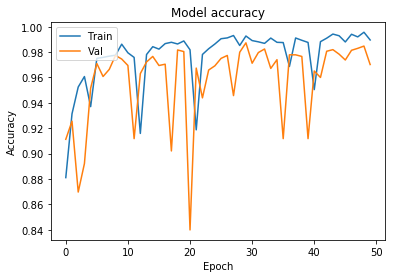

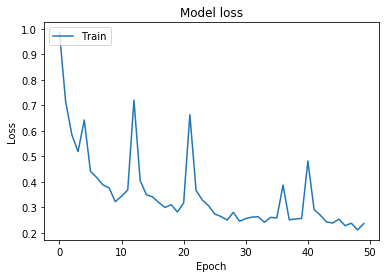

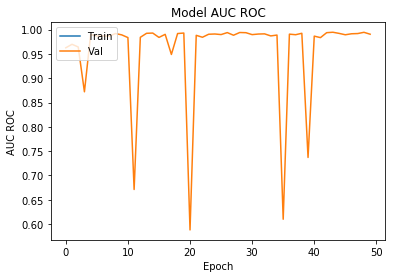

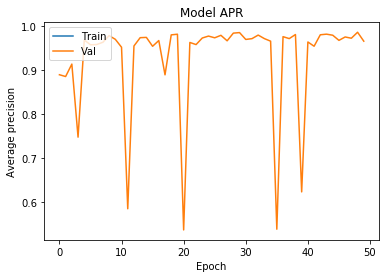

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(my_auc_callback.acc_val)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation AUC values
plt.plot(my_auc_callback.auc_trn)
plt.plot(my_auc_callback.auc_val)
plt.title('Model AUC ROC')
plt.ylabel('AUC ROC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation APR values
plt.plot(my_auc_callback.apr_trn)
plt.plot(my_auc_callback.apr_val)
plt.title('Model APR')
plt.ylabel('Average precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [20]:
print(comp_metrics(gen_tst, model))
print(comp_stats(gen_tst))

(0.9747513389441469, 0.9000255036980362, 0.9902397626661885, 0.9730729801772227)
[3529.  392.]


In [ ]:
model.save('trained_german.h5')